<a href="https://colab.research.google.com/github/gowriks12/Advanced-Computer-Vision-TF/blob/main/end2end.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install imageai
!pip install tensorflow
!pip install pickle-mixin
!pip install mediapipe
!pip install scikit-learn==1.0

In [ ]:
!pip install pydrive                             # Package to use Google Drive API - not installed in Colab VM by default
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive

from google.colab import auth                    # Other necessary packages
from oauth2client.client import GoogleCredentials

auth.authenticate_user()                         # Follow prompt in the authorization process
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()

drive = GoogleDrive(gauth)

your_module = drive.CreateFile({"id": "1Mt8zu_E33EByGSb3MNHN30voaSpOhmtq"})   # "your_module_file_id" is the part after "id=" in the shareable link
your_module.GetContentFile("PoseModule.py")          # Save the .py module file to Colab VM

In [2]:
# !pip install imageai
from imageai.Detection import ObjectDetection
import os
import pickle
from sklearn import preprocessing
import numpy as np
from google.colab.patches import cv2_imshow
import cv2
from skimage.color import rgb2gray
from skimage.transform import resize
import matplotlib.pyplot as plt
import math
import PoseModule as pm

In [ ]:
detector = ObjectDetection()
detector.setModelTypeAsRetinaNet()
execution_path = "/content/drive/MyDrive/Colab Notebooks/Thesis-object-detection"
detector.setModelPath( os.path.join(execution_path , "resnet50_coco_best_v2.1.0.h5"))
detector.loadModel()
poseDetector = pm.PoseDetector()
# poseDetector.poseClassifier()
loaded_model = pickle.load(open(os.path.join(execution_path , 'knn_r_pca_pipe.sav'), 'rb'))
# loaded_model = pickle.load(open(os.path.join(execution_path , 'rf_pipe_pickle.sav'), 'rb'))
custom_objects = detector.CustomObjects(person=True)
folder_path = '/content/drive/MyDrive/Colab Notebooks/Thesis-object-detection/frames'

output = []
count = 0
one_frame_each = 140
for filename in os.listdir(folder_path):
    if (count % one_frame_each == 0):                                   # checks frame number and keeps one_frame_each          
        # success,image = vidcap.read() 
        image = cv2.imread(os.path.join(folder_path , filename))
        op_img = "temp.jpg"                                # reads next frame           
        detections = detector.detectCustomObjectsFromImage(custom_objects=custom_objects, input_image=os.path.join(folder_path , filename), output_image_path=os.path.join(folder_path , op_img), minimum_percentage_probability=30)
        person_count = 0
        for eachObject in detections:
          person_count += 1
          if eachObject["percentage_probability"] > 65:
            boxPoints = eachObject["box_points"]
            x1, y1, x2, y2 = boxPoints
            top_left_x = min([x1,x2])
            top_left_y = min([y1,y2])
            bot_right_x = max([x1,x2])
            bot_right_y = max([y1,y2])
            cropped = image[top_left_y:bot_right_y+1, top_left_x:bot_right_x+1]
            # crop,className = poseDetector.poseClassifier(cropped, loaded_model)
            crop, className = poseDetector.poseClassifier(cropped, loaded_model)
            row = [count, person_count, eachObject["percentage_probability"], className]
            output.append(row)         
    else:
      print("err")
        # success,image = vidcap.read()                                 # reads next frame    
    count += 140 

print(output)

In [ ]:
output

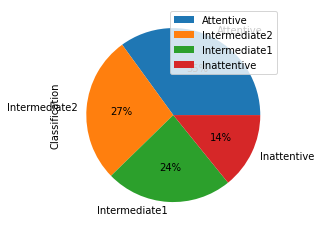

In [5]:
import pandas as pd
def dataAnalyse(df):  
  df = df.dropna()
  mapping = {
    "Hand_on_chin" : "Intermediate1",
    "Hand_on_head" : "Intermediate2",
    "Hand_raised" : "Attentive",
    "Hands_Crossed" : "Attentive",
    "Leaning_Forward" : "Intermediate1",
    "Looking_down" : "Intermediate2",
    "Looking_to_the_side" : "Inattentive",
    "Sitting_Straight" : "Attentive",
    "Sleeping" : "Inattentive",
    "Taking_Notes" : "Attentive"
  }
  df['Classification'] = df['Pose'].map(mapping)
  pie_data = pd.DataFrame(df['Classification'].value_counts(normalize=True) * 100)
  plot_image = pie_data.plot(kind='pie', y = "Classification", autopct='%1.0f%%')
  return plot_image


df = pd.DataFrame.from_records(output, columns = ["Frame No.", "Person No.", "Person Confidence", "Pose"])
img = dataAnalyse(df)

# df = pd.DataFrame.from_records(out, columns = ["Frame No.", "Person No.", "Person Confidence", "Pose"])

In [6]:
import csv
with open(os.path.join(execution_path , 'output_CSV.csv'), mode='w') as classification_file:
    classification_writer = csv.writer(classification_file, delimiter=',', quoting=csv.QUOTE_MINIMAL)
    classification_writer.writerow(["Frame No.", "Person No.", "Person Confidence", "Pose"])
    for row in output:
      classification_writer.writerow(row)

Preview of the Pie Chart

In [ ]:
# def single_person_pose(image,model):     
#   loaded_model = model
#   image = poseDetector.findPose(image, draw=False)
#   lmList = poseDetector.findPosition(image, draw=False)
#   if len(lmList) != 0:    
#     (row, image) = poseDetector.regionFeatures(lmList, image)
#     F = np.array([row])
#     F.reshape(1, -1)
#     # print(F.shape)
#     scaler = preprocessing.StandardScaler().fit(F)
#     row = scaler.transform(F)
#     prediction = loaded_model.predict(F)
#     className = prediction[0]
#     return image, className
#   else:
#     return (image, "null")